# Program for Landmarking

# Data loading and Settings

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import GroupShuffleSplit

from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw, concordance_index_censored
from lifelines import KaplanMeierFitter

# models 
from lifelines import CoxPHFitter
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB



# others
from numpy import inf
from random import sample
from collections import Counter
from sklearn.model_selection import KFold
import itertools

In [2]:
# ENS SURV module
from ens_surv.utils import *
from ens_surv.boot_kfold import boot_kfold

In [3]:
####################################################################################################################################
# loading data & preprop

# settings 
dir = "/Users/pio/Google 드라이브/data/"
file_name = "pbc2.csv"
data = pd.read_csv(dir + file_name)

# drop status1 - competing risks setting
data = data.drop(axis=1, columns =['status'])


# ID, Time, Event, Measure Time column names
ID_col = 'id'; T_col ='years'; E_col ='status2'; measure_T_col = 'year'

# categorical variables
nominal_col = ['drug','sex', 'ascites', 'hepatomegaly','spiders', 'edema']
ordinal_col = ['histologic']

# continuous variables
cont_col = list(set(data.columns) - set(nominal_col) - set(ordinal_col) - set([ID_col, T_col, E_col, measure_T_col]))

# window - 5 year prediction 
window = 5

# S : landmark time points - 0, 0.5, 1, ..., 10
S = np.linspace(0,10,21)
v_years = S+window

# Number of bins when discritizing 
## !!!(Actually, k_bin - 1 bins are produced)!!!
k_bin = 5

# minimal bin_size
minimal_bin_size = window / (k_bin-1)
# t_grid -> minimal points where survival probabilities are measured
# t_grid = np.arange(0,S[-1] + window + minimal_bin_size, step = minimal_bin_size)

# imputation -> fill na's : median for continous
for col in cont_col : 
    data[col] = data[col].fillna(data[col].median())


# one-hot encoding for categorical variables
data = pd.get_dummies(data, columns = nominal_col, drop_first=True)


####################################################################################################################################
# settings2

# proportion of train set
p_train = 0.7


# Train-test split & min-max scaling

In [4]:
from sklearn.preprocessing import MinMaxScaler

train, test = splitID(data = data,ID_col = ID_col, p = p_train)
print(train.shape)
print(test.shape)

print('Intersection : ', set(np.unique(train[ID_col])).intersection(set(np.unique(test[ID_col]))))


scaler = MinMaxScaler()

feature_cols = ['age','serBilir', 'serChol', 'albumin','alkaline', 'SGOT', 'platelets', 'prothrombin', 'histologic', 'status2','drug_placebo', 'sex_male', 'ascites_Yes', 'hepatomegaly_Yes',
'spiders_Yes', 'edema_edema despite diuretics','edema_edema no diuretics']


train[feature_cols] = scaler.fit_transform(train[feature_cols])
test[feature_cols] = scaler.transform(test[feature_cols])



(1370, 20)
(575, 20)
Intersection :  set()


In [5]:
train_lm1 = LM_transformer(df=train,ID_col = ID_col,T_col=T_col,E_col=E_col,window=window,S=S,measure_T_col=measure_T_col)
test_lm1 = LM_transformer(df=test,ID_col = ID_col,T_col=T_col,E_col=E_col,window=window,S=S,measure_T_col=measure_T_col)

train_lm2_train_ver = LM_transformer2(df=train_lm1,ID_col = ID_col,T_col=T_col,E_col=E_col,window=window,S=S,measure_T_col=measure_T_col,k_bin = k_bin, train=True)
train_lm2_validation_ver = LM_transformer2(df=train_lm1,ID_col = ID_col,T_col=T_col,E_col=E_col,window=window,S=S,measure_T_col=measure_T_col,k_bin = k_bin, train=False)

test_lm2 = LM_transformer2(df=test_lm1,ID_col = ID_col,T_col=T_col,E_col=E_col,window=window,S=S,measure_T_col=measure_T_col,k_bin = k_bin, train=False)

In [6]:
print(train.shape)
print(test.shape)

print(train_lm1.shape)
print(test_lm1.shape)

print(train_lm2_train_ver.shape)
print(train_lm2_validation_ver.shape)

print(test_lm2.shape)

(1370, 20)
(575, 20)
(2771, 21)
(1201, 21)
(8413, 21)
(11084, 21)
(4804, 21)


---

### No Bootstrapping version

In [7]:
np.log(np.linspace(1,1.5,10))

array([0.        , 0.05406722, 0.10536052, 0.15415068, 0.2006707 ,
       0.24512246, 0.28768207, 0.32850407, 0.36772478, 0.40546511])

In [8]:
np.log([1,2,3,4,5])

array([0.        , 0.69314718, 1.09861229, 1.38629436, 1.60943791])

In [41]:
# setting : 

# B : number of resampling / K : number of folds / boot : replacement true false
B = 1; K = 3; boot = False

base_info = {'ID_col':ID_col, 'T_col':T_col, 'E_col':E_col, 'measure_T_col':measure_T_col, 'boot':boot, 'B':B, 'K':K, 
            'window':window , 'S' :S, 'k_bin':k_bin}

# df list : in order of original, landmark 1, landmark 2(disc) train version, landmark 2(disc) validation ver 
train_df_list = [train, train_lm1, train_lm2_train_ver, train_lm2_validation_ver]
test_df_list = [test, test_lm1, test_lm2]

# model specifics : model name & model instance & hyperparameter grid & type of model
## type of model : cont(continous) or disc(discrete)

## model specifics of level 1 models
cox1_params = {'penalizer':[0,0.05,0.1,0.5],'l1_ratio':[0,0.25,0.5,0.75,1]}

model_specifics_cont = pd.DataFrame({'model_name' : ['cox1'], 
                                'model_instance':[CoxPHFitter()], 
                                'hyperparams':[cox1_params], 
                                'type':['cont']})

LR_params = {'C':[0.05,  10]}
RF_params = {'n_estimators':[50,100,300,500],'max_depth':[1,3,5]}
GB_params = {'n_estimators':[50,100,300,500],'max_depth':[1,3,5]}
MLP_params = {'hidden_layer_sizes':[1,2,3], 'activation' : ['identity', 'logistic', 'tanh', 'relu'], 'max_iter' : [1000], 'early_stopping' : [True], 'learning_rate' : ['adaptive']}
KNN_params = {'n_neighbors':[1,5,10], 'weights':['uniform', 'distance']}
NGB_params = {'var_smoothing':[1e-5, 1e-9, 1e-1]}
ADA_params = {'n_estimators':[50,100,300,500], 'learning_rate':[0.1,0.25,0.75,1]}



model_specifics_disc = pd.DataFrame({'model_name' : ['LR','RF','GB','MLP','KNN','NGB','ADA'], 
                                'model_instance':[LogisticRegression(max_iter=10000),RandomForestClassifier(),GradientBoostingClassifier(),MLPClassifier(),KNeighborsClassifier(),GaussianNB(), AdaBoostClassifier()], 
                                'hyperparams':[LR_params, RF_params, GB_params,MLP_params, KNN_params,NGB_params, ADA_params], 
                                'type':['disc','disc','disc','disc','disc','disc','disc']})


model_specifics_1 = pd.concat([model_specifics_cont,model_specifics_disc],axis=0).reset_index(drop=True)

## model specifics of level 2 models
model_specifics_2 = pd.DataFrame({'model_name':['M1'], 
                                  'model_instance':[LogisticRegression(max_iter=10000)],
                                  'hyperparams':[{'C':[0.05, 10]}],
                                 })






In [23]:
# model 정보 - 순서대로...
for g_1 in range(model_specifics_1.shape[0]) :
    model_name = model_specifics_1.loc[g_1,'model_name'] 
    model_instance = model_specifics_1.loc[g_1,'model_instance']
    model_hyperparams = model_specifics_1.loc[g_1,'hyperparams']
    model_type = model_specifics_1.loc[g_1,'type']
    
    param_combinations = list(itertools.product(*list(model_hyperparams.values())))
    param_names = list(model_hyperparams.keys())
    
    print(model_name)
    print(model_instance)
    print(param_combinations)
    print(param_names)

            
    

cox1
<lifelines.CoxPHFitter>
[(0, 0), (0, 0.25), (0, 0.5), (0, 0.75), (0, 1), (0.05, 0), (0.05, 0.25), (0.05, 0.5), (0.05, 0.75), (0.05, 1), (0.1, 0), (0.1, 0.25), (0.1, 0.5), (0.1, 0.75), (0.1, 1), (0.5, 0), (0.5, 0.25), (0.5, 0.5), (0.5, 0.75), (0.5, 1)]
['penalizer', 'l1_ratio']
LR
LogisticRegression(max_iter=10000)
[(0.05,), (10,)]
['C']
RF
RandomForestClassifier()
[(50, 1), (50, 3), (50, 5), (100, 1), (100, 3), (100, 5), (300, 1), (300, 3), (300, 5), (500, 1), (500, 3), (500, 5)]
['n_estimators', 'max_depth']
GB
GradientBoostingClassifier()
[(50, 1), (50, 3), (50, 5), (100, 1), (100, 3), (100, 5), (300, 1), (300, 3), (300, 5), (500, 1), (500, 3), (500, 5)]
['n_estimators', 'max_depth']
MLP
MLPClassifier()
[(1, 'identity', 1000, True, 'adaptive'), (1, 'logistic', 1000, True, 'adaptive'), (1, 'tanh', 1000, True, 'adaptive'), (1, 'relu', 1000, True, 'adaptive'), (2, 'identity', 1000, True, 'adaptive'), (2, 'logistic', 1000, True, 'adaptive'), (2, 'tanh', 1000, True, 'adaptive'), (2, 

In [25]:
stacked_noboot = boot_kfold(base_info = base_info, 
           train_df_list = train_df_list, 
           test_df_list = test_df_list,
           model_specifics_1 = model_specifics_1, 
           model_specifics_2 = model_specifics_2)
           

In [26]:
stacked_noboot.boot_stack()

######################################################################
1 / 1  Resampled
1 / 3  fold
$$$
Iteration :  1
cox1
LR
RF
GB
MLP
KNN
NGB
ADA
2 / 3  fold
$$$
Iteration :  2
cox1
LR
RF
GB
MLP
KNN
NGB
ADA
3 / 3  fold
$$$
Iteration :  3
cox1
LR
RF
GB
MLP
KNN
NGB
ADA
cox1
LR
RF
GB
MLP
KNN
NGB
ADA


([array([[1.        , 0.93221564, 0.93221564, ..., 0.06283403, 0.06284157,
          0.06278973],
         [1.        , 0.96520746, 0.96520746, ..., 0.06282915, 0.06291319,
          0.06291218],
         [1.        , 0.9746575 , 0.9746575 , ..., 0.06250737, 0.06279437,
          0.06271187],
         ...,
         [1.        , 0.68676182, 0.68676182, ..., 0.06182927, 0.06219508,
          0.06215712],
         [1.        , 0.98215865, 0.98215865, ..., 0.06226845, 0.06252715,
          0.06273201],
         [1.        , 0.91729122, 0.91729122, ..., 0.06255947, 0.0626817 ,
          0.06287055]])],
 [[       id      years       age      year  serBilir   serChol   albumin  \
   0       2  14.152338  0.578364  0.000000  0.022059  0.143605  0.434211   
   1       2  14.152338  0.578364  0.498302  0.014706  0.131395  0.355263   
   2       2  14.152338  0.578364  0.999343  0.019608  0.131395  0.347953   
   3       2  14.152338  0.578364  2.102727  0.041667  0.131395  0.402047   
   4      

In [28]:
sum(np.isnan(stacked_noboot.test_superset[0]))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [36]:
for i in range(1, stacked_noboot.test_superset[0].shape[1]) : 
    print(sq_error(stacked_noboot.test_superset[0][:,0], stacked_noboot.test_superset[0][:,i]))

0.17337676929971182
0.17337676929971182
0.17337676929971182
0.17337676929971182
0.17337676929971182
0.1729783737711008
0.1730232769899531
0.17306856786622724
0.1731142497863525
0.17316032617421404
0.17258833024245895
0.17267484646973608
0.17276287547222993
0.17285244377611553
0.17294357849433264
0.16975455741148127
0.17006717634303584
0.170410646580051
0.17078777419308622
0.17120168039322864
0.16864248594274137
0.17030391279212212
0.1770534346680856
0.16011517641467302
0.16602160800383828
0.1717525125962945
0.1657819929298408
0.16771096159747595
0.1737406020513137
0.15929927485954662
0.16067127784155405
0.1731913471973224
0.15965663446844627
0.16244127544906717
0.1538925692771166
0.16295012185715335
0.178695992163794
0.1568000981012702
0.1816775967397174
0.1839254451850932
0.16650031018945763
0.2019038810162077
0.20255327511632112
0.17219812882655797
0.2169963619224608
0.21746008017227084
0.3633332307830853
0.597022718220034
0.29513864997832606
0.5105026376349489
0.2458280451713845
0.6

In [37]:
reg_nnls = LinearRegression(positive=True, fit_intercept=False)

level_2_nnls = []
for b in range(B) :
    # Fitting 2nd model on bth super set
    X = stacked_noboot.train_supersets[b][:,1:]
    y = stacked_noboot.train_supersets[b][:,0]
    w = stacked_noboot.weights[b]*(10**5)
    
    reg_nnls_temp = clone(reg_nnls)
    reg_nnls_temp.fit(X,y,w)
    
    # Predict on test_superset
    test_X = stacked_noboot.test_superset[b][:,1:]
    test_y = stacked_noboot.test_superset[b][:,0]
    pred = reg_nnls_temp.predict(test_X)
    print(sq_error(test_y, pred))

0.15179740181797644


---

### Bootstrapping version

In [44]:
# setting : 

# B : number of resampling / K : number of folds / boot : replacement true false
B = 10; K = 3; boot = False

base_info = {'ID_col':ID_col, 'T_col':T_col, 'E_col':E_col, 'measure_T_col':measure_T_col, 'boot':boot, 'B':B, 'K':K, 
            'window':window , 'S' :S, 'k_bin':k_bin}

# df list : in order of original, landmark 1, landmark 2(disc) train version, landmark 2(disc) validation ver 
train_df_list = [train, train_lm1, train_lm2_train_ver, train_lm2_validation_ver]
test_df_list = [test, test_lm1, test_lm2]

# model specifics : model name & model instance & hyperparameter grid & type of model
## type of model : cont(continous) or disc(discrete)

## model specifics of level 1 models
cox1_params = {'penalizer':[0,0.05,0.1,0.5],'l1_ratio':[0,0.25,0.5,0.75,1]}

model_specifics_cont = pd.DataFrame({'model_name' : ['cox1'], 
                                'model_instance':[CoxPHFitter()], 
                                'hyperparams':[cox1_params], 
                                'type':['cont']})

LR_params = {'C':[0.05,  10]}
RF_params = {'n_estimators':[50,100,300,500],'max_depth':[1,3,5]}
GB_params = {'n_estimators':[50,100,300,500],'max_depth':[1,3,5]}
MLP_params = {'hidden_layer_sizes':[1,2,3], 'activation' : ['identity', 'logistic', 'tanh', 'relu'], 'max_iter' : [1000], 'early_stopping' : [True], 'learning_rate' : ['adaptive']}
KNN_params = {'n_neighbors':[1,5,10], 'weights':['uniform', 'distance']}
NGB_params = {'var_smoothing':[1e-5, 1e-9, 1e-1]}
ADA_params = {'n_estimators':[50,100,300,500], 'learning_rate':[0.1,0.25,0.75,1]}



model_specifics_disc = pd.DataFrame({'model_name' : ['LR','RF','GB','MLP','KNN','NGB','ADA'], 
                                'model_instance':[LogisticRegression(max_iter=10000),RandomForestClassifier(),GradientBoostingClassifier(),MLPClassifier(),KNeighborsClassifier(),GaussianNB(), AdaBoostClassifier()], 
                                'hyperparams':[LR_params, RF_params, GB_params,MLP_params, KNN_params,NGB_params, ADA_params], 
                                'type':['disc','disc','disc','disc','disc','disc','disc']})


model_specifics_1 = pd.concat([model_specifics_cont,model_specifics_disc],axis=0).reset_index(drop=True)

## model specifics of level 2 models
model_specifics_2 = pd.DataFrame({'model_name':['M1'], 
                                  'model_instance':[LogisticRegression(max_iter=10000)],
                                  'hyperparams':[{'C':[0.05, 10]}],
                                 })







In [45]:
stacked = boot_kfold(base_info = base_info, 
           train_df_list = train_df_list, 
           test_df_list = test_df_list,
           model_specifics_1 = model_specifics_1, 
           model_specifics_2 = model_specifics_2)
           

In [46]:
stacked.boot_stack()

######################################################################
1 / 10  Resampled
1 / 3  fold
$$$
Iteration :  1
cox1
LR
RF
GB
MLP
KNN
NGB
ADA
2 / 3  fold
$$$
Iteration :  2
cox1
LR
RF
GB
MLP
KNN
NGB
ADA
3 / 3  fold
$$$
Iteration :  3
cox1
LR
RF
GB
MLP
KNN
NGB
ADA
cox1
LR
RF
GB
MLP
KNN
NGB
ADA
######################################################################
2 / 10  Resampled
1 / 3  fold
$$$
Iteration :  1
cox1
LR
RF
GB
MLP
KNN
NGB
ADA
2 / 3  fold
$$$
Iteration :  2
cox1
LR
RF
GB
MLP
KNN
NGB
ADA
3 / 3  fold
$$$
Iteration :  3
cox1
LR
RF
GB
MLP
KNN
NGB
ADA
cox1
LR
RF
GB
MLP
KNN
NGB
ADA
######################################################################
3 / 10  Resampled
1 / 3  fold
$$$
Iteration :  1
cox1
LR
RF
GB
MLP
KNN
NGB
ADA
2 / 3  fold
$$$
Iteration :  2
cox1
LR
RF
GB
MLP
KNN
NGB
ADA
3 / 3  fold
$$$
Iteration :  3
cox1
LR
RF
GB
MLP
KNN
NGB
ADA
cox1
LR
RF
GB
MLP
KNN
NGB
ADA
######################################################################
4 / 10  Resampled
1 / 3

([array([[1.        , 0.93042012, 0.93042012, ..., 0.06268414, 0.0625044 ,
          0.06291853],
         [1.        , 0.97665734, 0.97665734, ..., 0.06263603, 0.06268627,
          0.06298619],
         [1.        , 0.9468842 , 0.9468842 , ..., 0.06257118, 0.06266478,
          0.06276604],
         ...,
         [1.        , 0.88050227, 0.88050227, ..., 0.06286418, 0.06283121,
          0.06276908],
         [1.        , 0.79842853, 0.79842853, ..., 0.06261266, 0.06263552,
          0.06254512],
         [1.        , 0.34077412, 0.34077412, ..., 0.06257199, 0.06245774,
          0.06250975]]),
  array([[1.        , 0.37187281, 0.37187281, ..., 0.06205161, 0.0621298 ,
          0.06208674],
         [1.        , 0.9797326 , 0.9797326 , ..., 0.06274371, 0.06284446,
          0.06270831],
         [1.        , 0.98749784, 0.98749784, ..., 0.06272094, 0.06263046,
          0.0625189 ],
         ...,
         [1.        , 0.90865468, 0.90865468, ..., 0.06310867, 0.06300555,
          0.0

In [48]:
reg_nnls = LinearRegression(positive=True, fit_intercept=False)

level_2_nnls = []; score = []
for b in range(B) :
    # Fitting 2nd model on bth super set
    X = stacked.train_supersets[b][:,1:]
    y = stacked.train_supersets[b][:,0]
    w = stacked.weights[b]*(10**5)
    
    reg_nnls_temp = clone(reg_nnls)
    reg_nnls_temp.fit(X,y,w)
    
    # Predict on test_superset
    test_X = stacked.test_superset[b][:,1:]
    test_y = stacked.test_superset[b][:,0]
    pred = reg_nnls_temp.predict(test_X)    
    print(b+1)
    print(sq_error(test_y, pred))
    score.append(sq_error(test_y, pred))

    level_2_nnls.append(pred)
    
    s_ = 0
    for b_ in range(b) :
        s_ = s_ + level_2_nnls[b_]
        
    b_th_mean_pred = s_ / (b+1)
    print(sq_error(b_th_mean_pred,test_y))
    print('######')


    


1
0.1511258969612682
0.7105022831050228
######
2
0.1525096835901648
0.2541910061197629
######
3
0.15870376716196882
0.19160747550241883
######
4
0.48148971107305205
0.16298806772131047
######
5
0.14835630913004283
0.14528470668495977
######
6
0.14749626131029372
0.14489510526115346
######
7
0.15596124497203598
0.14449347268203488
######
8
0.14316316104905574
0.1444575909167641
######
9
0.14870960972464767
0.1440024109973832
######
10
0.15590314935705715
0.14412473738931988
######


In [49]:
np.mean(score)

0.18434187943295868

---

# 결과 모으기

In [50]:
print(test_df_list[0].shape)
print(test_df_list[1].shape)
print(test_df_list[2].shape)

(535, 20)
(1095, 21)
(4380, 21)


In [51]:
result_store = test_df_list[1][[ID_col, 'LM',E_col, T_col]].copy()
result_store['survival'] = abs(result_store[E_col]-1)
result_store.head()

,id,LM,status2,years,survival
0,1,0.0,1.0,1.095170,0.0
1,3,0.0,1.0,2.770781,0.0
2,17,0.0,1.0,2.105465,0.0
3,18,0.0,1.0,0.361406,0.0
4,21,0.0,0.0,5.000000,1.0


In [52]:
# individual models
result_store = pd.concat([result_store, pd.DataFrame(stacked_noboot.test_superset[0][:,1:])], axis=1)

In [53]:
b=0
X = stacked_noboot.train_supersets[b][:,1:]
y = stacked_noboot.train_supersets[b][:,0]
w = stacked_noboot.weights[b]*(10**5)

reg_nnls_temp = clone(reg_nnls)
reg_nnls_temp.fit(X,y,w)

# Predict on test_superset
test_X = stacked_noboot.test_superset[b][:,1:]
test_y = stacked_noboot.test_superset[b][:,0]
pred = reg_nnls_temp.predict(test_X)

In [54]:
result_store = pd.concat([result_store, pd.DataFrame(pred, columns = ['nnls'])], axis=1)

In [56]:
reg_nnls = LinearRegression(positive=True, fit_intercept=False)

level_2_nnls = []; score = []
B=10
for b in range(B) :
    # Fitting 2nd model on bth super set
    X = stacked.train_supersets[b][:,1:]
    y = stacked.train_supersets[b][:,0]
    w = stacked.weights[b]*(10**5)
    
    reg_nnls_temp = clone(reg_nnls)
    reg_nnls_temp.fit(X,y,w)
    
    # Predict on test_superset
    test_X = stacked.test_superset[b][:,1:]
    test_y = stacked.test_superset[b][:,0]
    pred = reg_nnls_temp.predict(test_X)    
#    print(b+1)
#    print(sq_error(test_y, pred))
    score.append(sq_error(test_y, pred))

    level_2_nnls.append(pred)
    
    s_ = 0
    for b_ in range(b) :
        s_ = s_ + level_2_nnls[b_]
        
    b_th_mean_pred = s_ / (b+1)
#    print(sq_error(b_th_mean_pred,test_y))
    

result_store = pd.concat([result_store, pd.DataFrame(b_th_mean_pred, columns =['nnls+boot'])], axis=1)

---
## RF model

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
# no bagging
rf = RandomForestClassifier()

level_2_rf = []
B=1
for b in range(B) :
    # Fitting 2nd model on bth super set
    X = stacked_noboot.train_supersets[b][:,1:]
    y = stacked_noboot.train_supersets[b][:,0]
    w = stacked_noboot.weights[b]*(10**5)
    
    temp = clone(rf)
    temp.fit(X,y,w)
    
    # Predict on test_superset
    test_X = stacked_noboot.test_superset[b][:,1:]
    test_y = stacked_noboot.test_superset[b][:,0]
    pred = temp.predict_proba(test_X)[:,1]
    print(sq_error(test_y, pred))

0.16108803652968037


In [60]:
result_store = pd.concat([result_store, pd.DataFrame(pred, columns = ['rf'])], axis=1)

In [62]:
# bagging
rf = RandomForestClassifier()

level_2_rf = []; score = []
B=10
for b in range(B) :
    # Fitting 2nd model on bth super set
    X = stacked.train_supersets[b][:,1:]
    y = stacked.train_supersets[b][:,0]
    w = stacked.weights[b]*(10**5)
    
    temp = clone(rf)
    temp.fit(X,y,w)
    
    # Predict on test_superset
    test_X = stacked.test_superset[b][:,1:]
    test_y = stacked.test_superset[b][:,0]
    pred = temp.predict_proba(test_X)[:,1]
    print('####')
    print(b+1)
    print(sq_error(test_y, pred))
    score.append(sq_error(test_y, pred))

    level_2_rf.append(pred)
    
    for b_ in range(b) : 
        s_ = 0
        for b_ in range(b) :
            s_ = s_ + level_2_rf[b_]

        b_th_mean_pred = s_ / (b+1)
    print(sq_error(b_th_mean_pred,test_y))


####
1
0.1665581735159817
0.1577086721461187
####
2
0.16075808219178084
0.29017378995433796
####
3
0.1525199086757991
0.2252989852866565
####
4
0.1623260273972603
0.19039442922374428
####
5
0.16116776255707763
0.17453451689497718
####
6
0.16016785388127855
0.1662765474378488
####
7
0.16419616438356166
0.16158352623241076
####
8
0.16926958904109587
0.15938583761415526
####
9
0.15598949771689496
0.15885976774339028
####
10
0.1580834703196347
0.15653610045662103


In [63]:
result_store = pd.concat([result_store, pd.DataFrame(b_th_mean_pred, columns =['rf+boot'])], axis=1)

In [65]:
result_store

,id,LM,status2,years,survival,0,1,2,3,4,...,77,78,79,80,81,82,nnls,nnls+boot,rf,rf+boot
0,1,0.0,1.0,1.095170,0.0,4.349033e-03,4.349033e-03,4.349033e-03,4.349033e-03,4.349033e-03,...,0.062056,0.061980,0.062250,0.062392,0.062364,0.062413,0.118469,0.200358,0.47,0.417
1,3,0.0,1.0,2.770781,0.0,1.033888e-01,1.033888e-01,1.033888e-01,1.033888e-01,1.033888e-01,...,0.062631,0.062589,0.062874,0.062566,0.062490,0.062716,0.353507,0.428644,0.62,0.483
2,17,0.0,1.0,2.105465,0.0,6.239368e-01,6.239368e-01,6.239368e-01,6.239368e-01,6.239368e-01,...,0.062710,0.062693,0.062665,0.062687,0.062654,0.062707,0.532967,0.613246,0.70,0.594
3,18,0.0,1.0,0.361406,0.0,2.820188e-07,2.820188e-07,2.820188e-07,2.820188e-07,2.820188e-07,...,0.062234,0.062448,0.062623,0.062546,0.062440,0.062419,0.112044,0.214540,0.38,0.370
4,21,0.0,0.0,5.000000,1.0,5.183617e-01,5.183617e-01,5.183617e-01,5.183617e-01,5.183617e-01,...,0.062808,0.062925,0.061989,0.062504,0.062544,0.062669,0.700631,0.799985,0.87,0.767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,96,10.0,0.0,12.375424,1.0,9.425923e-01,9.425923e-01,9.425923e-01,9.425923e-01,9.425923e-01,...,0.062827,0.062999,0.062808,0.062802,0.062773,0.062688,0.845565,0.909768,0.88,0.769
1091,122,10.0,0.0,10.858614,1.0,8.718365e-01,8.718365e-01,8.718365e-01,8.718365e-01,8.718365e-01,...,0.062666,0.062795,0.062351,0.062580,0.062583,0.062557,0.672634,0.769233,0.81,0.727
1092,124,10.0,1.0,10.686124,0.0,5.669427e-08,5.669427e-08,5.669427e-08,5.669427e-08,5.669427e-08,...,0.062361,0.062520,0.057539,0.062464,0.062462,0.057724,0.415162,0.552636,0.86,0.715
1093,140,10.0,0.0,10.206987,1.0,8.902269e-01,8.902269e-01,8.902269e-01,8.902269e-01,8.902269e-01,...,0.062699,0.062551,0.062914,0.062709,0.062611,0.062485,0.756230,0.849453,0.85,0.751


In [67]:
from sksurv.metrics import concordance_index_censored

In [71]:
arr = []
for lm in S : 
    temp_df = result_store[result_store['LM']==lm]
    #print('###')
    #print(lm)
    arr2 = []
    for i in range(5,temp_df.shape[1]) : 
        c_index_at_lm = concordance_index_censored((temp_df[E_col] == 1), temp_df[T_col], 1-temp_df.iloc[:,i], tied_tol=1e-08)
        arr2.append(c_index_at_lm[0])
        #print(temp_df.columns[i])
        #print(np.round(c_index_at_lm[0],4))
    arr.append(arr2)

dat_c_index = pd.DataFrame(np.array(arr))
dat_c_index.columns = ['model : ' + str(temp_df.columns[i]) for i in range(5,temp_df.shape[1])]
dat_c_index['LM'] = S



###
0.0
0
0.8482
1
0.8482
2
0.8482
3
0.8482
4
0.8482
5
0.8482
6
0.8482
7
0.8482
8
0.8482
9
0.8482
10
0.8482
11
0.8482
12
0.8482
13
0.8482
14
0.8486
15
0.8454
16
0.8462
17
0.847
18
0.8474
19
0.8474
20
0.8482
21
0.8443
22
0.8401
23
0.8707
24
0.8784
25
0.8576
26
0.8647
27
0.8784
28
0.8639
29
0.88
30
0.8827
31
0.8627
32
0.876
33
0.8764
34
0.8737
35
0.8854
36
0.8494
37
0.8741
38
0.869
39
0.8529
40
0.8737
41
0.8599
42
0.8543
43
0.869
44
0.8513
45
0.8609
46
0.2201
47
0.3335
48
0.3597
49
0.4445
50
0.5037
51
0.4876
52
0.3601
53
0.5
54
0.2319
55
0.2401
56
0.4406
57
0.4443
58
0.6605
59
0.6605
60
0.7913
61
0.7929
62
0.7862
63
0.7995
64
0.8733
65
0.8725
66
0.8309
67
0.8805
68
0.8568
69
0.7744
70
0.6397
71
0.7419
72
0.7183
73
0.7321
74
0.8227
75
0.6234
76
0.7791
77
0.8439
78
0.7685
79
0.7462
80
0.696
81
0.7862
82
0.7878
nnls
0.8596
nnls+boot
0.869
rf
0.8586
rf+boot
0.8709
###
0.5
0
0.8455
1
0.8455
2
0.8455
3
0.8455
4
0.8455
5
0.8455
6
0.8455
7
0.8455
8
0.8455
9
0.8455
10
0.8455
11
0.8455
12
0.8455
1

In [83]:
LM_l = [] ; model_l = []; value_l = []
for lm in S : 
    temp_df = result_store[result_store['LM']==lm]
    for i in range(5,temp_df.shape[1]) : 
        c_index_at_lm = concordance_index_censored((temp_df[E_col] == 1), temp_df[T_col], 1-temp_df.iloc[:,i], tied_tol=1e-08)
        LM_l.append(lm); model_l.append(temp_df.columns[i]); value_l.append(c_index_at_lm[0])
        




In [85]:
dat_c_index = pd.DataFrame({'LM':LM_l, 'Model':model_l, 'C index':value_l})

In [140]:
dat_c_index_base = dat_c_index[(dat_c_index.Model != 'nnls')&(dat_c_index.Model != 'nnls+boot')&(dat_c_index.Model != 'rf')&(dat_c_index.Model != 'rf+boot')]
dat_c_index_2nd = dat_c_index[(dat_c_index.Model == 'nnls')|(dat_c_index.Model == 'nnls+boot')|(dat_c_index.Model == 'rf')|(dat_c_index.Model == 'rf+boot')]

In [163]:
dat_c_index_base.to_csv('/Users/pio/Google 드라이브/github/survival ensemble/'+'dat_c_index_base.csv',encoding='utf-8')
dat_c_index_2nd.to_csv('/Users/pio/Google 드라이브/github/survival ensemble/'+'dat_c_index_2nd.csv',encoding='utf-8')

In [157]:
np.round(dat_c_index_base[['LM','C index']].groupby('LM').describe().reset_index(), 3)

LM C index                                                 
           count   mean    std    min    25%    50%    75%    max
0    0.0    83.0  0.762  0.172  0.220  0.757  0.848  0.859  0.885
1    0.5    83.0  0.755  0.167  0.218  0.736  0.843  0.846  0.878
2    1.0    83.0  0.742  0.161  0.252  0.729  0.825  0.841  0.857
3    1.5    83.0  0.727  0.154  0.260  0.712  0.802  0.823  0.848
4    2.0    83.0  0.735  0.147  0.242  0.701  0.816  0.819  0.853
5    2.5    83.0  0.735  0.149  0.247  0.699  0.817  0.819  0.849
6    3.0    83.0  0.689  0.118  0.261  0.669  0.737  0.756  0.821
7    3.5    83.0  0.684  0.122  0.305  0.648  0.747  0.753  0.826
8    4.0    83.0  0.672  0.130  0.297  0.615  0.744  0.761  0.813
9    4.5    83.0  0.669  0.122  0.274  0.610  0.732  0.753  0.807
10   5.0    83.0  0.628  0.099  0.340  0.567  0.667  0.685  0.763
11   5.5    83.0  0.641  0.085  0.261  0.637  0.658  0.688  0.722
12   6.0    83.0  0.719  0.140  0.203  0.660  0.794  0.810  0.828
13   6.5    83.0  0.634  0.105  0.218  0.591  0.686  0.695  0.741
14   7.0    83.0  0.591  0.078  0.338  0.556  0.603  0.656  0.689
15   7.5    83.0  0.708  0.145  0.244  0.628  0.767  0.811  0.867
16   8.0    83.0  0.707  0.137  0.256  0.650  0.772  0.800  0.861
17   8.5    83.0  0.666  0.156  0.216  0.657  0.725  0.750  0.882
18   9.0    83.0  0.790  0.249  0.029  0.735  0.912  0.971  1.000
19   9.5    83.0  0.813  0.233  0.048  0.667  0.905  1.000  1.000
20  10.0    83.0  0.792  0.237  0.143  0.619  0.857  1.000  1.000

In [159]:
dat_c_index_2nd.loc[dat_c_index_2nd.Model == 'nnls']

,LM,Model,C index
83,0.0,nnls,0.859553
170,0.5,nnls,0.866915
257,1.0,nnls,0.854884
344,1.5,nnls,0.843194
431,2.0,nnls,0.836463
518,2.5,nnls,0.837087
605,3.0,nnls,0.768730
692,3.5,nnls,0.794271
779,4.0,nnls,0.786999
866,4.5,nnls,0.779259


In [164]:
dat_c_index_2nd.loc[dat_c_index_2nd.Model == 'nnls+boot']

,LM,Model,C index
84,0.0,nnls+boot,0.868968
171,0.5,nnls+boot,0.864123
258,1.0,nnls+boot,0.856014
345,1.5,nnls+boot,0.840896
432,2.0,nnls+boot,0.839491
519,2.5,nnls+boot,0.835586
606,3.0,nnls+boot,0.779587
693,3.5,nnls+boot,0.794271
780,4.0,nnls+boot,0.789765
867,4.5,nnls+boot,0.785185


In [165]:
dat_c_index_2nd.loc[dat_c_index_2nd.Model == 'rf']

,LM,Model,C index
85,0.0,rf,0.858572
172,0.5,rf,0.833178
259,1.0,rf,0.842180
346,1.5,rf,0.820505
433,2.0,rf,0.791641
520,2.5,rf,0.819444
607,3.0,rf,0.766015
694,3.5,rf,0.751953
781,4.0,rf,0.791148
868,4.5,rf,0.805926


In [166]:
dat_c_index_2nd.loc[dat_c_index_2nd.Model == 'rf+boot']

,LM,Model,C index
86,0.0,rf+boot,0.870930
173,0.5,rf+boot,0.844346
260,1.0,rf+boot,0.849238
347,1.5,rf+boot,0.847501
434,2.0,rf+boot,0.820109
521,2.5,rf+boot,0.833333
608,3.0,rf+boot,0.788817
695,3.5,rf+boot,0.779297
782,4.0,rf+boot,0.800138
869,4.5,rf+boot,0.791111


---- 
# OLD

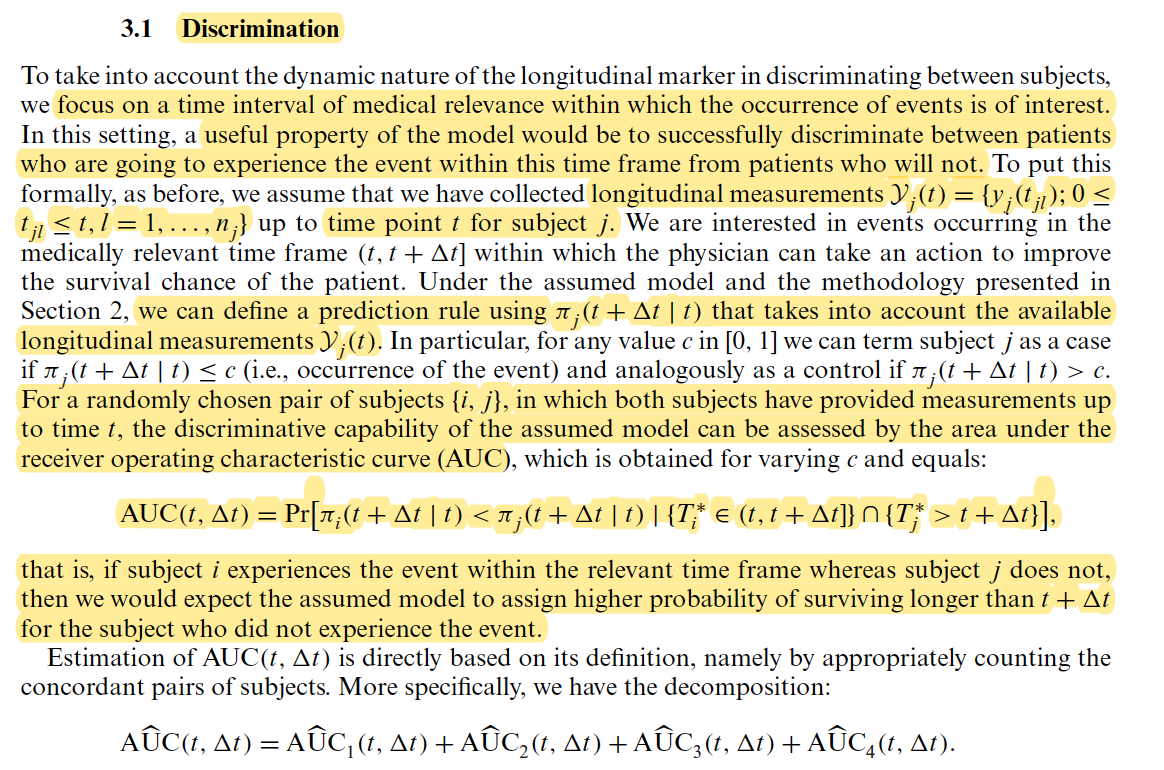
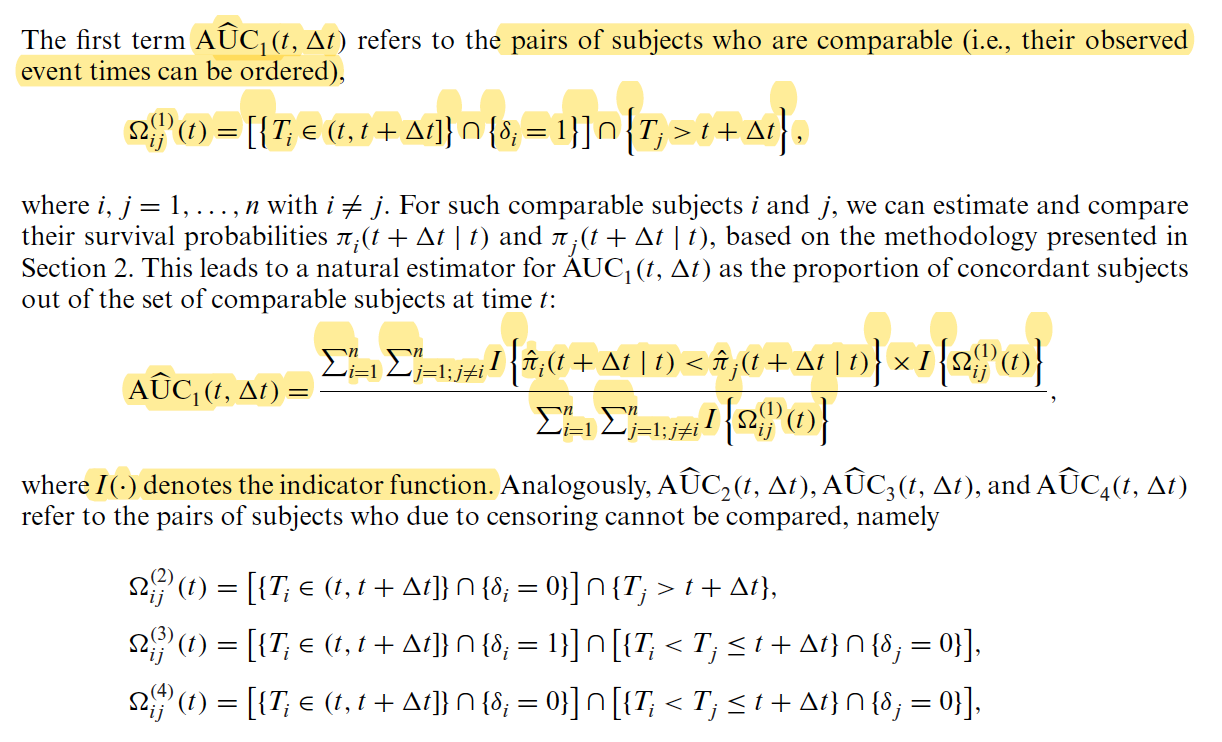

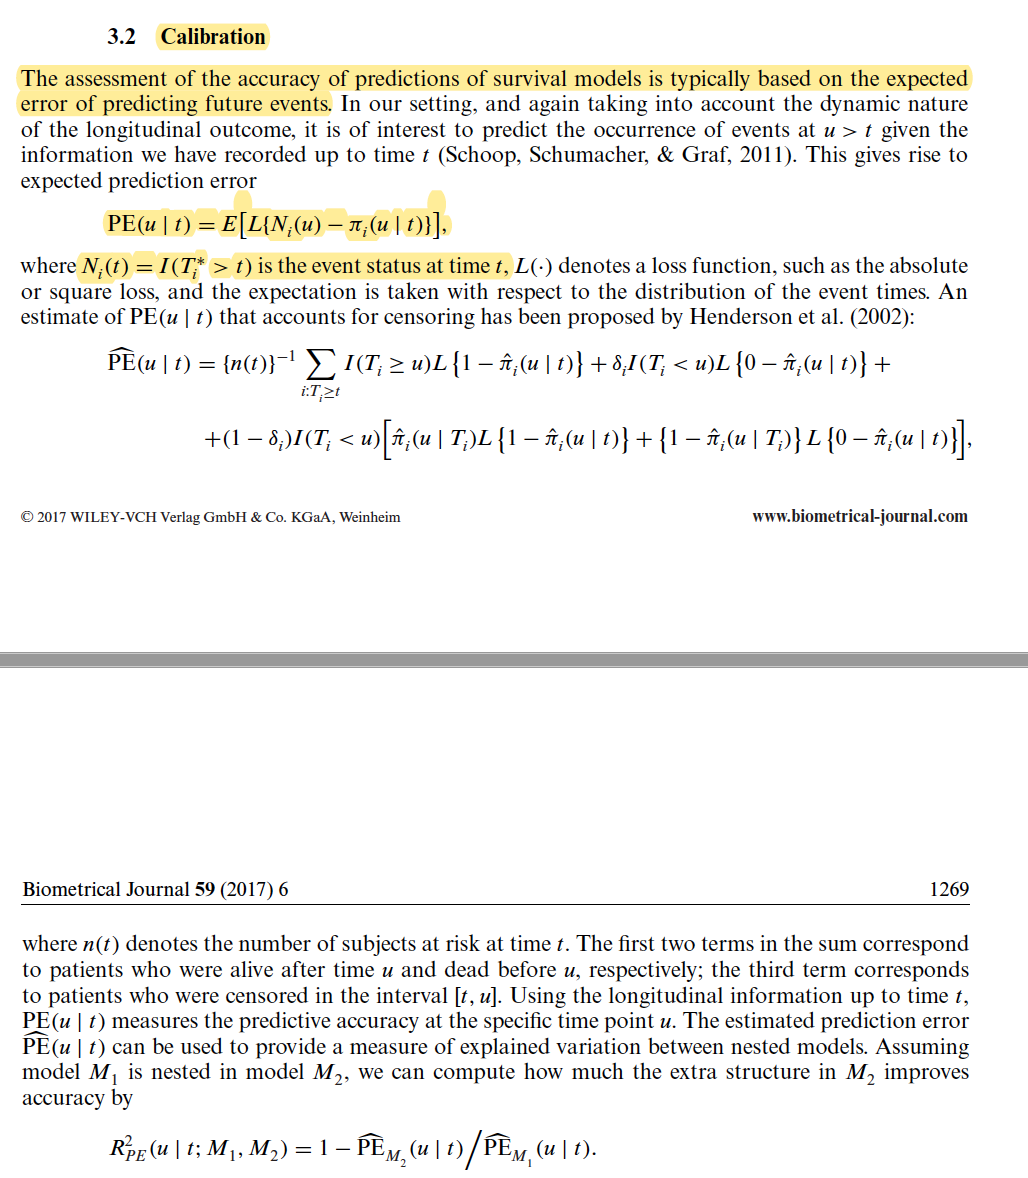

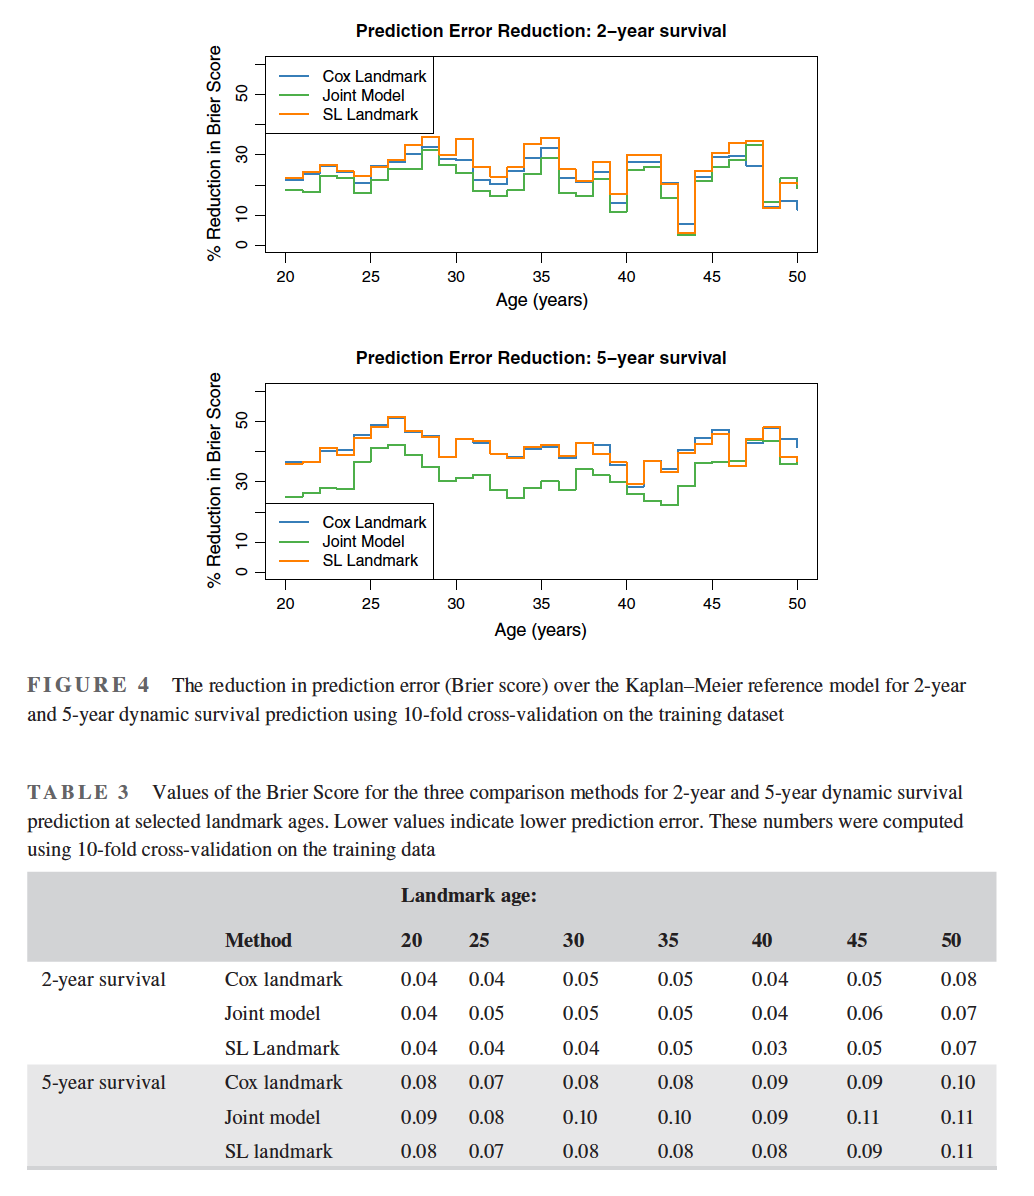

# ---------------------------------

# Plan of action 

## Models with K-folds and no bagging : No bootstrapping / K-fold(super set)
- M1 : non-negative weighted linear regression 
- M2 : logistic regression with binary cross entropy loss
- M3 : Ensemble selection(with replacement) a.k.a hill climbing
- M4 : Another 2nd level models such as Lasso, RF, GB... 

## Models with k-folds and bagging : return averaged survival estimates from B bagged 2nd level models

- M1' : M1 + bagging
- M2' : M2 + bagging 
- M3' : M3 + bagging
- M4' : M4 + bagging

## Models with k-folds and bagging + different methods

- M5(PROPOSE) : Ensemble Selection(with replacement) + stepwise Bagging
    - M3' + Stepwise selection
    - For every b, b = 1, 2, 3, ... , B, super set is obtained thru k-folds
    - And Ensemble "STEPWISE" Selection on super set
    - Stopping when score in oob samples are converged.
    - 장점 : overfitting 여부 예측 가능. When to stop?에 대한 해결책 제공
    
## Models with Gate controll
- M6(PROPOSE) : Gate control fusion 



In [ ]:
def splitID(data = data, ID = ID_col, p = p_train) :
    # Unique ID names
    unique_ids = np.unique(data[ID_col])

    # Number of samples within each train and test set
    n_train = round(len(unique_ids)*0.7)
    n_test = len(unique_ids) - n_train
    
    # IDs within train set and test set
    train_ids = list(sample(set(unique_ids), n_train))
    test_ids = list(set(unique_ids).difference(set(train_ids)))

    # Row-wise masking for train and test set
    mask_train = data[ID_col].isin(train_ids)
    mask_test = data[ID_col].isin(test_ids)

    # final train and test sets
    data_train = data[mask_train].reset_index(drop=True)
    data_test = data[mask_test].reset_index(drop=True)
    
    return data_train, data_test

    

In [ ]:
train, test = splitID(data = data, ID = ID_col, p = p_train)
print(train.shape)
print(test.shape)

print('Intersection : ', set(np.unique(train[ID_col])).intersection(set(np.unique(test[ID_col]))))

In [ ]:
train, test = splitID(data = data, ID = ID_col, p = p_train)
print(train.shape)
print(test.shape)

print('Intersection : ', set(np.unique(train[ID_col])).intersection(set(np.unique(test[ID_col]))))

train_lm1 = LM_transformer(df=train)
test_lm1 = LM_transformer(df=test)

# 
train_lm2_train_ver = LM_transformer2(df=train_lm1,train=True)
train_lm2_validation_ver = LM_transformer2(df=train_lm1,train=False)

test_lm2 = LM_transformer2(df=test_lm1,train=False)

# Models with K-folds and no bagging : No bootstrapping / K-fold(super set)
- M1 : non-negative weighted linear regression 
- M2 : logistic regression with binary cross entropy loss
- M3 : Ensemble selection(with replacement) a.k.a hill climbing
- M4 : Another 2nd level models such as Lasso, RF, GB... 



In [ ]:
BOOTSTRAP_STACKS_1

## M1 : non-negative weighted linear regression

## M2 : logistic regression with binary cross entropy loss


## M3 : Ensemble selection(with replacement) a.k.a hill climbing

## M4 : Another 2nd level models such as Lasso, RF, GB...